# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time

In [2]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1 #Fix Collab PTX issue; source : https://github.com/googlecolab/colabtools/issues/5081

 # FROM PREVIOUS LABS :

In [3]:
img = plt.imread('usth.jpg')
img = img.astype(np.uint16)
h, w, _ = img.shape
pixel_count = h * w
flat_img = img.reshape(pixel_count, 3)

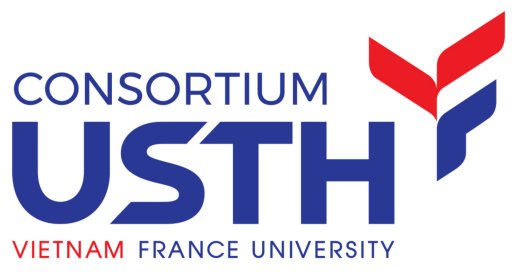

In [4]:
plt.imshow(img)
plt.axis('off')
plt.show()

# LAB 5 WITHOUT SHARED MEMORY

In [14]:
from numba import cuda
import numpy as np
import time
import matplotlib.pyplot as plt
@cuda.jit
def gaussian_blur_global(src, dst, width, height):
    x, y = cuda.grid(2)
    #Convert to a linear index in the 1D image array
    tid = y * width + x
    kernel = (
        (1, 2, 3, 4, 3, 2, 1),
        (2, 3, 4, 5, 4, 3, 2),
        (3, 4, 6, 8, 6, 4, 3),
        (4, 5, 8,16, 8, 5, 4),
        (3, 4, 6, 8, 6, 4, 3),
        (2, 3, 4, 5, 4, 3, 2),
        (1, 2, 3, 4, 3, 2, 1)
    )
    kernel_sum = 256
    if x < width and y < height:
        r = g = b = 0.0
        for ky in range(-3, 4):
            for kx in range(-3, 4):
                nx = x + kx
                ny = y + ky
                #Check for valid neighbor
                if 0 <= nx < width and 0 <= ny < height:
                    n_tid = ny * width + nx
                    w = kernel[ky + 3][kx + 3]
                    r += src[n_tid, 0] * w
                    g += src[n_tid, 1] * w
                    b += src[n_tid, 2] * w
        #Normalize
        dst[tid, 0] = np.uint16(r / kernel_sum)
        dst[tid, 1] = np.uint16(g / kernel_sum)
        dst[tid, 2] = np.uint16(b / kernel_sum)


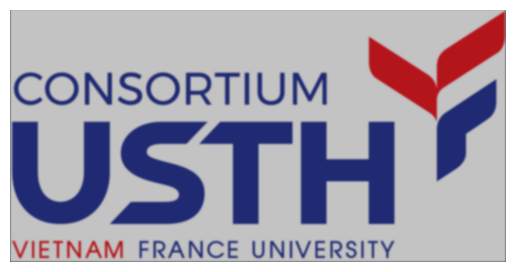

Global memory time: 0.33583545684814453


In [15]:
start_gpu = time.time()
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

blockSize = (16, 16)
gridSize = (
    (w + blockSize[0] - 1) // blockSize[0],
    (h + blockSize[1] - 1) // blockSize[1]
)


gaussian_blur_global[gridSize, blockSize](devSrc, devDst, w, h)
cuda.synchronize()

hostDst = devDst.copy_to_host()

end_gpu = time.time()
time_gpu = end_gpu - start_gpu

plt.imshow(hostDst.reshape((h, w, 3)))
plt.axis('off')
plt.show()

print("Global memory time:", time_gpu)


In [16]:
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

block_sizes = [(8,8), (16,16), (32,8), (8,32), (32,16), (16,32), (32,32)]

for blockSize in block_sizes:
    gridSize = (
        (w + blockSize[0] - 1) // blockSize[0],
        (h + blockSize[1] - 1) // blockSize[1]
    )

    start_gpu = time.time()
    gaussian_blur_global[gridSize, blockSize](devSrc, devDst, w, h)
    cuda.synchronize()
    hostDst = devDst.copy_to_host()
    end_gpu = time.time()

    time_gpu = end_gpu - start_gpu
    print(blockSize, "time:", time_gpu)


(8, 8) time: 0.004634857177734375
(16, 16) time: 0.004647254943847656
(32, 8) time: 0.004503726959228516
(8, 32) time: 0.004622936248779297
(32, 16) time: 0.004587888717651367
(16, 32) time: 0.004599809646606445
(32, 32) time: 0.004673480987548828


#Lab 5 shared memory

In [17]:
@cuda.jit
def gaussian_blur_shared(src, dst, width, height):
    x, y = cuda.grid(2)
    tid = y * width + x
    #Shared memory
    kernel_shared = cuda.shared.array((7, 7), dtype=np.int32)
    if cuda.threadIdx.x < 7 and cuda.threadIdx.y < 7:
        base_kernel = (
            (1, 2, 3, 4, 3, 2, 1),
            (2, 3, 4, 5, 4, 3, 2),
            (3, 4, 6, 8, 6, 4, 3),
            (4, 5, 8,16, 8, 5, 4),
            (3, 4, 6, 8, 6, 4, 3),
            (2, 3, 4, 5, 4, 3, 2),
            (1, 2, 3, 4, 3, 2, 1)
        )
        kernel_shared[cuda.threadIdx.y, cuda.threadIdx.x] = base_kernel[cuda.threadIdx.y][cuda.threadIdx.x]

    cuda.syncthreads()
    kernel_sum = 256
    if x < width and y < height:
        r = g = b = 0.0
        for ky in range(-3, 4):
            for kx in range(-3, 4):
                nx = x + kx
                ny = y + ky
                if 0 <= nx < width and 0 <= ny < height:
                    n_tid = ny * width + nx
                    w = kernel_shared[ky + 3, kx + 3]
                    r += src[n_tid, 0] * w
                    g += src[n_tid, 1] * w
                    b += src[n_tid, 2] * w
        dst[tid, 0] = np.uint16(r / kernel_sum)
        dst[tid, 1] = np.uint16(g / kernel_sum)
        dst[tid, 2] = np.uint16(b / kernel_sum)


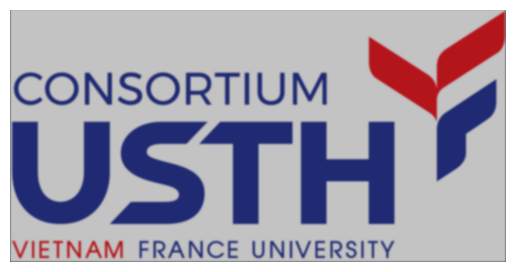

Shared memory time: 0.3087928295135498


In [18]:
start_gpu = time.time()

devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

blockSize = (16, 16)
gridSize = (
    (w + blockSize[0] - 1) // blockSize[0],
    (h + blockSize[1] - 1) // blockSize[1]
)

gaussian_blur_shared[gridSize, blockSize](devSrc, devDst, w, h)
cuda.synchronize()

hostDst = devDst.copy_to_host()
end_gpu = time.time()
time_gpu = end_gpu - start_gpu

plt.imshow(hostDst.reshape((h, w, 3)))
plt.axis('off')
plt.show()

print("Shared memory time:", time_gpu)


In [20]:
devSrc = cuda.to_device(flat_img)
devDst = cuda.device_array((pixel_count, 3), np.uint16)

block_sizes = [(8,8), (16,16), (32,8), (8,32), (32,16), (16,32), (32,32)]

for blockSize in block_sizes:
    gridSize = (
        (w + blockSize[0] - 1) // blockSize[0],
        (h + blockSize[1] - 1) // blockSize[1]
    )

    start_gpu = time.time()
    gaussian_blur_shared[gridSize, blockSize](devSrc, devDst, w, h)
    cuda.synchronize()
    hostDst = devDst.copy_to_host()
    end_gpu = time.time()

    time_gpu = end_gpu - start_gpu
    print(blockSize, "time:", time_gpu)


(8, 8) time: 0.00471186637878418
(16, 16) time: 0.004605770111083984
(32, 8) time: 0.004491329193115234
(8, 32) time: 0.004508018493652344
(32, 16) time: 0.004548311233520508
(16, 32) time: 0.00453495979309082
(32, 32) time: 0.004824399948120117
